In [1]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
def fit(X, Y):
    dictionary = {}
    dictionary['total_data_points'] = Y.shape[0]
    all_classes = set(Y[:, 0])
    for current_class in all_classes:
        dictionary[current_class] = {}
        cur_class_lis = (Y[:, 0] == current_class)
        X_current = X[cur_class_lis]
        Y_current = Y[cur_class_lis]
        dictionary[current_class]['total_count'] = Y_current.shape[0]
        num_features = X.shape[1]
        for feature in range(num_features):
            dictionary[current_class][feature] = {}
            discrete_vals = set(X[:, feature])
            ##MODDED LINE TO MAKE IT SPECIFIC for TRUE/FALSE VALUES
            discrete_vals.add(1)
            discrete_vals.add(0)
            ##Remove the code between comments to make it generic.
            for v in discrete_vals:
                dictionary[current_class][feature][v] = (X_current[:, feature] == v).sum()
    return dictionary

In [0]:
def probability(dictionary, x, cur_class):
    cur_prob = np.log(dictionary[cur_class]['total_count']) - np.log(dictionary['total_data_points'])
    for feat in range(x.shape[0]):
        n = dictionary[cur_class][feat][x[feat]] + 1
        d = dictionary[cur_class]['total_count'] + len(dictionary[cur_class][feat].keys())
        cur_prob = cur_prob  + np.log(n) - np.log(d)
    return cur_prob

In [0]:
def predict_single(dictionary, x):
    pred_prob = -1000
    pred_class = -2
    all_classes = dictionary.keys()
    for cur_class in all_classes:
        if cur_class is 'total_data_points':
            continue
        cur_prob = probability(dictionary, x, cur_class)
        if cur_prob > pred_prob:
            pred_prob = cur_prob
            pred_class = cur_class
    return pred_class, pred_prob

In [0]:
def predict(dictionary, X):
    pred_probs = []
    Y_pred = []
    for x in X:
        y, p = predict_single(dictionary, x)
        Y_pred.append(y)
        pred_probs.append(p)
    Y_pred = np.array(Y_pred)
    Y_pred = np.reshape(Y_pred, (len(Y_pred), 1))
    
    pred_probs = np.array(pred_probs)
    pred_probs = np.reshape(pred_probs, (len(pred_probs), 1))
    return Y_pred, pred_probs

In [0]:
def clean_data(X):
    punct = "~!@#$%^&*()_-+={}|:\"<>?[]\\;\',."
    stops = stopwords.words('english')
    stops = [''.join([ch for ch in word if ch not in punct]) for word in stops]
    X = [''.join([ch for ch in sent if ch not in punct]).lower() for sent in X]
    X = [' '.join(sent.split()[1:]) for sent in X]
    X = [' '.join([word for word in sent.split() if word not in stops]) for sent in X]
    return X

In [0]:
##Now my data has been cleansed of stopwords, punctuation marks, etc. So I need to use some NLTK tools
##for better results
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

##This function converst the tag given by pos_tag to the TAG used in wordnetlemmatizer
def get_simple_postag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def nltk_cleaning(X):
    lemma = WordNetLemmatizer()
    new_X = []
    for sentence in X:
        new_sentence = []
        all_words = sentence.split()
        for word in all_words:
            tag_for_word = pos_tag([word])[0][1]
            reduced_word = lemma.lemmatize(word, get_simple_postag(tag_for_word))
            new_sentence.append(reduced_word)
        new_sentence = ' '.join(new_sentence)
        new_X.append(new_sentence)
    return new_X

In [0]:
def form_raw_dictionary(X):
    dictionary = {}
    for sentence in X:
        words = sentence.split()
        for word in words:
            if word in dictionary.keys():
                dictionary[word] += 1
            else:
                dictionary[word] = 1
    return dictionary

In [0]:
def get_features(X, num_feat = 100):
    X = clean_data(X)
    X = nltk_cleaning(X)
    dictionary = form_raw_dictionary(X)
    a = sorted(dictionary.items(), key = lambda x: x[1], reverse = True)
    a = a[: min(len(a), num_feat)] ##a is now a list of tuples
    a = [x[0] for x in a]
    return a

In [0]:
##Use this function to convert continuous distribution to discrete intervals.
def cvtColumn(col):
    x = []
    for val in col:
        if val == 0:
            x.append(0)
        elif val == 1:
            x.append(1)
        else:
            x.append(2)
    return np.array(x)

In [0]:
def transform_data(X, features):
    X_tf = []
    for x in X:
        tf = []
        all_words = set(x.split())
        for word in features:
            if word in all_words:
                tf.append(1)
            else:
                tf.append(0)
        X_tf.append(tf)
    X_tf = np.array(X_tf)
    #for i in range(len(features)):
    #    X_tf[:, i] = cvtColumn(X_tf[:, i])
    return np.array(X_tf)

In [17]:
##In this note, we'll be loading the data and converting into numpy arrays to maintain uniformity
raw = pd.read_csv('train_data.csv')
X = raw['text']
Y = raw['airline_sentiment']
X = np.array(X)
Y = np.array(Y).reshape(-1, 1)

FileNotFoundError: ignored

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [16]:
##For performance evaluation, we'll be plotting the accuracy vs the number of features.
#x_axis = []
#y_axis = []
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 27)
#nf = 10
#while nf <= 1000:
feats = get_features(X_train, num_feat = 960)
X_train_tf = transform_data(X_train, feats)
X_test_tf = transform_data(X_test, feats)
dictionary = fit(X_train_tf, Y_train)
Y_pred_test, Y_pred_probs = predict(dictionary, X_test_tf)
acc = ((Y_pred_test == Y_test).sum() / Y_pred_test.shape[0]) * 100
print(acc)
#print(np.e ** Y_pred_probs)
#x_axis.append(nf)
#y_axis.append(acc)
#nf += 50

NameError: ignored

20


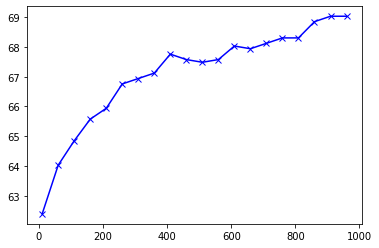

None


In [0]:
##Accuracy plotted in this note.
import matplotlib.pyplot as plt
plt.plot(x_axis, y_axis, marker = 'x', color = 'blue')
print(len(x_axis))
print(plt.show())

In [0]:
##So from now on, we'll be looking at the accuracies achieved from other classifiers such as 
##Random forest classifier, SVM, MultinomialNB, NLTK's inbuilt NB classifier.
##We'll look at which classifier performs the best.

In [0]:
from nltk.classify.scikitlearn import SklearnClassifier
##Use this function to convert your data into the format required by the NLTK Classifiers.
def cvt_processed_data_to_dictionary_format(X, Y, features):
    data = []
    for j in range(X.shape[0]):
        dictionary = {}
        for i in range(len(features)):
            if X[j][i] == 1:
                dictionary[features[i]] = True
            else:
                dictionary[features[i]] = False
        data.append((dictionary, list(Y[j])[0]))
    return data

data_train = cvt_processed_data_to_dictionary_format(X_train_tf, Y_train, feats)
data_test = cvt_processed_data_to_dictionary_format(X_test_tf, Y_test, feats)

In [0]:
from nltk import NaiveBayesClassifier
clf_nltk_nb = NaiveBayesClassifier.train(data_train)
acc_nltk_nb = nltk.classify.accuracy(clf_nltk_nb, data_test)
print(acc_nltk_nb)
clf_nltk_nb.show_most_informative_features(10)

0.6876138433515483
Most Informative Features
                    hold = True           negati : positi =     35.4 : 1.0
               wonderful = True           positi : negati =     32.0 : 1.0
                   thank = True           positi : negati =     25.9 : 1.0
                favorite = True           positi : negati =     21.7 : 1.0
                     min = True           negati : neutra =     20.1 : 1.0
               excellent = True           positi : negati =     19.2 : 1.0
                     job = True           positi : neutra =     17.8 : 1.0
                 awesome = True           positi : negati =     17.5 : 1.0
                   visit = True           neutra : negati =     16.6 : 1.0
                   raise = True           positi : negati =     16.6 : 1.0


In [0]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_tf, Y_train)
score = clf_rf.score(X_test_tf, Y_test)
print(score)

/home/kanishk/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.644808743169399


In [0]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
clf_mnb = MultinomialNB()
clf_mnb.fit(X_train_tf, Y_train)
acc_mnb = clf_mnb.score(X_test_tf, Y_test)
print(acc_mnb)

clf_gnb = GaussianNB()
clf_gnb.fit(X_train_tf, Y_train)
acc_gnb = clf_gnb.score(X_test_tf, Y_test)
print(acc_gnb)

0.6548269581056466


/home/kanishk/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kanishk/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.29690346083788705


In [0]:
from sklearn.svm import SVC
clf_svm = SVC()
clf_svm.fit(X_train_tf, Y_train)
acc_svm = clf_mnb.score(X_test_tf, Y_test)
print(acc_svm)

/home/kanishk/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kanishk/.local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.6548269581056466


In [0]:
##As it turned out, OUR SELF IMPLEMENTED NAIVE BAYES PERFORMED THE BEST WITH AN ACCURACY OF ABOUT 69%.